In [ ]:
# Remove any conflicting preinstalls (optional but helps avoid surprises)
!pip uninstall -y numpy tensorflow keras h5py

# Install a compatible stack for Py 3.12
!pip install -U --no-cache-dir \
  "numpy==1.26.4" \
  "tensorflow==2.17.1" \
  "h5py==3.11.0" \
  rasterio patchify

# 🔄 Force a clean runtime restart so new binary wheels load
import os, sys
os.kill(os.getpid(), 9)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: h5py 3.14.0
Uninstalling h5py-3.14.0:
  Successfully uninstalled h5py-3.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 305.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 195.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 268.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 353.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 235.7 MB/s eta 0:00:00

In [ ]:
import numpy as np, tensorflow as tf
print("NumPy:", np.__version__)      # should be 1.26.4
print("TensorFlow:", tf.__version__) # should be 2.17.1

NumPy: 1.26.4
TensorFlow: 2.17.1


In [ ]:
# =============================
# 0) INSTALLS & IMPORTS
# =============================
#!pip -q install rasterio patchify

import tensorflow as tf
import os, math, gc
import numpy as np
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# =============================
# 1) CONFIG — EDIT THESE PATHS
# =============================
workingFolder = '/content/drive/MyDrive/path_to_your_image/'
outputFolder = '/content/drive/MyDrive/path_for_output/'
# Test for before and after event

#S1_TIF_PATH = workingFolder+'20250708_Ascending_S1A_IW_GRDH_1SDV_20250708T100123_20250708T100148_059991_0773E3_04DF.tif'

#S1_TIF_PATH = workingFolder+'20250720_Ascending_S1A_IW_GRDH_1SDV_20250720T100123_20250720T100148_060166_0779E8_0D7B.tif'

S1_TIF_PATH = workingFolder+'20250801_Ascending_S1A_IW_GRDH_1SDV_20250801T100123_20250801T100148_060341_077FEB_B8A2.tif'

# Test for Descending
#S1_TIF_PATH = workingFolder+'20250710_Descending_S1A_IW_GRDH_1SDV_20250710T215251_20250710T215316_060027_07751C_D4E6.tif'

#S1_TIF_PATH = workingFolder+'20250716_Descending_S1C_IW_GRDH_1SDV_20250716T215148_20250716T215213_003251_006909_9570.tif'

#S1_TIF_PATH = workingFolder+'20250722_Descending_S1A_IW_GRDH_1SDV_20250722T215250_20250722T215315_060202_077B21_CCFD.tif'

#S1_TIF_PATH = workingFolder+'20250728_Descending_S1C_IW_GRDH_1SDV_20250728T215149_20250728T215214_003426_006E2F_A157.tif'

MODEL_H5     = workingFolder+'attention_unet_model_landslide_250epoch.h5'       # <-- change me
OUT_MASK_TIF = outputFolder+'Asc_S1_pred_mask_0801_S1A.tif'   # uint8 0/1
OUT_PROB_TIF = outputFolder+'Asc_S1_pred_prob_0801_S1A.tif'   # float32 probability (optional)

PATCH_SIZE   = 256
BATCH_SIZE   = 8            # adjust per VRAM/CPU
ADD_RVI_IF_NEEDED = True     # auto-add RVI if model needs 3 channels but image has 2
THRESHOLD    = 0.5           # for binary mask
USE_ROBUST_SCALING = True    # percentile scaling (2–98) per-band
PRINT_SHAPES = True

In [ ]:
# =============================
# 2) READ IMAGE (keeps georef)
# =============================
with rasterio.open(S1_TIF_PATH) as src:
    profile  = src.profile.copy()
    crs      = src.crs
    transform= src.transform
    nodata   = src.nodata
    # Read all bands -> (bands, H, W)
    arr = src.read()  # dtype could be float32/float64/int16, values often dB or linear
    band_names = list(range(1, src.count+1))  # index-based; TIFF doesn't store VV/VH names

# Move to (H, W, C)
arr = np.transpose(arr, (1, 2, 0)).astype(np.float32)
H, W, C = arr.shape
if PRINT_SHAPES:
    print(f"Read image shape: H={H}, W={W}, C={C}; dtype={arr.dtype}")


Read image shape: H=1115, W=1114, C=3; dtype=float32


In [ ]:
# --- Config: which bands are VV/VH, and whether your data are in dB ---
VV_IDX, VH_IDX = 0, 1
DB_TO_LINEAR = True   # set True if your S1 bands are in dB (typical); False if already linear

def to_linear(x_db):
    # x_db can be array in dB; convert to linear power
    return np.power(10.0, x_db / 10.0, dtype=np.float32)
def compute_rvi_from_vv_vh(vv, vh, from_db=True, eps=1e-6):
    """
    Dual-pol RVI approximation: RVI = 4 * VH / (VV + VH) using *linear* power.
    If inputs are in dB, set from_db=True to convert first.
    """
    if from_db:
        vv_lin = to_linear(vv.astype(np.float32))
        vh_lin = to_linear(vh.astype(np.float32))
    else:
        vv_lin = vv.astype(np.float32)
        vh_lin = vh.astype(np.float32)
    rvi = 4.0 * vh_lin / (vv_lin + vh_lin + eps)
    return np.clip(rvi, 0.0, 4.0).astype(np.float32)

# 1) Compute RVI from the raw VV/VH (before any normalization)
vv = arr[..., VV_IDX]
vh = arr[..., VH_IDX]
rvi = compute_rvi_from_vv_vh(vv, vh, from_db=DB_TO_LINEAR)

# 2) Stack VV, VH, RVI → (H, W, 3)
arr_with_rvi = np.dstack([vv.astype(np.float32), vh.astype(np.float32), rvi])

In [ ]:
# =============================
# 3) LOAD MODEL
# =============================
model = tf.keras.models.load_model(MODEL_H5, compile=False)
in_shape = model.input_shape  # e.g., (None, 256, 256, 2/3)
if isinstance(in_shape, list):
    in_shape = in_shape[0]
_, ph, pw, in_channels = in_shape
if PRINT_SHAPES:
    print("Model expects input shape:", in_shape)

# Make sure patch size matches:
assert ph == PATCH_SIZE and pw == PATCH_SIZE, \
    f"Model expects {ph}x{pw}; but PATCH_SIZE={PATCH_SIZE}. Change PATCH_SIZE or resize the model."

# If model expects 3 channels and we only have 2, optionally add RVI
# if in_channels == 3 and arr_scaled.shape[-1] == 2 and ADD_RVI_IF_NEEDED:
#     rvi = add_rvi(arr)
#     arr_scaled = np.dstack([arr_scaled, rvi.astype(np.float32)])
#     C = 3
# if PRINT_SHAPES:
#     print("Scaled image shape going into patchify:", arr_scaled.shape)


Model expects input shape: (None, 256, 256, 3)


In [ ]:
# 3) Normalize AFTER adding RVI (robust 2–98% per-band)
def robust_scale(img_hw_c, qmin=2, qmax=98):
    out = np.empty_like(img_hw_c, dtype=np.float32)
    for i in range(img_hw_c.shape[-1]):
        band = img_hw_c[..., i]
        lo, hi = np.nanpercentile(band, [qmin, qmax])
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            lo, hi = float(np.nanmin(band)), float(np.nanmax(band))
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            out[..., i] = 0.0
        else:
            out[..., i] = np.clip((band - lo) / (hi - lo), 0, 1)
    return out

# 3b) Normalize AFTER adding RVI (min–max per-band)
def minmax_scale(img_hw_c):
    """
    Min–max normalize each band in img_hw_c to [0,1].
    Handles NaNs and constant bands safely.
    """
    out = np.empty_like(img_hw_c, dtype=np.float32)
    for i in range(img_hw_c.shape[-1]):
        band = img_hw_c[..., i]
        lo, hi = np.nanmin(band), np.nanmax(band)
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            out[..., i] = 0.0
        else:
            out[..., i] = (band - lo) / (hi - lo)
    return out

# Example usage:
arr_scaled = minmax_scale(arr_with_rvi)   # (H, W, C) in [0,1]

# arr_scaled = robust_scale(arr_with_rvi)  # (H, W, 3) in [0,1]

# 4) Match model channels
#    - If model expects 3 channels: use [VV, VH, RVI] normalized (arr_scaled as-is)
#    - If model expects 2 channels: pick the first two (VV, VH)
#    - If model expects 1 channel: choose one (e.g., RVI) -> arr_scaled[..., 2:3]
in_shape = model.input_shape
if isinstance(in_shape, list):
    in_shape = in_shape[0]
_, ph, pw, in_channels = in_shape

if in_channels == 3:
    data_for_model = arr_scaled
elif in_channels == 2:
    data_for_model = arr_scaled[..., :2]          # VV, VH
elif in_channels == 1:
    data_for_model = arr_scaled[..., 2:3]         # RVI only
else:
    raise ValueError(f"Unsupported model input channels: {in_channels}")

print("Final tensor for model:", data_for_model.shape, " (H,W,C)")

Final tensor for model: (1115, 1114, 3)  (H,W,C)


In [ ]:
# =============================
# 4) PAD TO MULTIPLES OF 256 (no overlap)
# =============================
pad_h = (math.ceil(H / PATCH_SIZE) * PATCH_SIZE) - H
pad_w = (math.ceil(W / PATCH_SIZE) * PATCH_SIZE) - W

if pad_h > 0 or pad_w > 0:
    arr_pad = np.pad(
        arr_scaled,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode='reflect'
    )
else:
    arr_pad = arr_scaled

Hp, Wp, _ = arr_pad.shape
if PRINT_SHAPES:
    print(f"Padded to: H={Hp}, W={Wp}, C={arr_pad.shape[-1]}")

Padded to: H=1280, W=1280, C=3


In [ ]:
# =============================
# 5) PATCHIFY (no overlap)
# =============================
# For 3D (H, W, C) and patch size (256,256,C), step=(256,256,C)
patches = patchify(arr_pad, (PATCH_SIZE, PATCH_SIZE, in_channels),
                   step=(PATCH_SIZE, PATCH_SIZE, in_channels))
# Result shape: (ny, nx, 1, 256,256,C) → squeeze the "1"
patches = np.squeeze(patches, axis=2)
ny, nx, ph2, pw2, ch2 = patches.shape
if PRINT_SHAPES:
    print(f"Patches grid: ny={ny}, nx={nx}, each patch: {ph2}x{pw2}x{ch2}")

# Flatten to N, H, W, C for batch prediction
patches_4d = patches.reshape(ny * nx, PATCH_SIZE, PATCH_SIZE, in_channels)

Patches grid: ny=5, nx=5, each patch: 256x256x3


In [ ]:
# =============================
# 6) PREDICT IN BATCHES
# =============================
# Handle both binary (1 channel) and multi-class outputs.
# We'll infer output depth from a small test call.
test_out = model.predict(patches_4d[:1], verbose=1)
if test_out.ndim == 4:
    out_h, out_w, out_c = test_out.shape[1:]
else:
    raise ValueError(f"Unexpected model output shape: {test_out.shape}")

# Predict all
pred_all = []
for i in range(0, patches_4d.shape[0], BATCH_SIZE):
    batch = patches_4d[i:i+BATCH_SIZE]
    pred = model.predict(batch, verbose=0)
    pred_all.append(pred.astype(np.float32))
pred_all = np.concatenate(pred_all, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


In [ ]:
# =============================
# 7) POST-PROCESS: to mask/prob
# =============================
# If out_c == 1 → binary prob; if out_c > 1 → softmax classes; take argmax
if out_c == 1:
    # Probability [0..1]
    pred_prob = pred_all[..., 0]
    pred_mask = (pred_prob >= THRESHOLD).astype(np.uint8)
else:
    # Multi-class → argmax
    pred_class = np.argmax(pred_all, axis=-1).astype(np.uint8)
    # Choose one class as “positive” (e.g., landslide=1) if you want a binary mask
    pred_mask = (pred_class == 1).astype(np.uint8)
    # Optional probability of the positive class:
    pred_prob = pred_all[..., 1] if pred_all.shape[-1] > 1 else None

# Put back into (ny, nx, ph, pw) and unpatchify
pred_mask_blocks = pred_mask.reshape(ny, nx, PATCH_SIZE, PATCH_SIZE)
pred_mask_4un = pred_mask_blocks[:, :, :, :][:, :, :, :]  # clarity

# Unpatchify needs shape (ny, nx, ph, pw) → to (Hp, Wp)
recon_mask = unpatchify(pred_mask_4un, (Hp, Wp))



# Same for probability (if available)
recon_prob = None
if pred_prob is not None:
    pred_prob_blocks = pred_prob.reshape(ny, nx, PATCH_SIZE, PATCH_SIZE)
    recon_prob = unpatchify(pred_prob_blocks, (Hp, Wp)).astype(np.float32)

# Crop back to original size
recon_mask = recon_mask[:H, :W]
if recon_prob is not None:
    recon_prob = recon_prob[:H, :W]

In [ ]:
# =============================
# 8) SAVE GEOREFERENCED OUTPUTS
# =============================
# Save mask (uint8: 0/1)
mask_profile = profile.copy()
mask_profile.update({
    'count': 1,
    'dtype': 'uint8',
    'compress': 'LZW',
    'nodata': 0
})
with rasterio.open(OUT_MASK_TIF, 'w', **mask_profile) as dst:
    dst.write(recon_mask.astype(np.uint8), 1)

# Optional: save probability (float32)
if recon_prob is not None:
    prob_profile = profile.copy()
    prob_profile.update({
        'count': 1,
        'dtype': 'float32',
        'compress': 'LZW',
        'nodata': None
    })
    with rasterio.open(OUT_PROB_TIF, 'w', **prob_profile) as dst:
        dst.write(recon_prob.astype(np.float32), 1)

print("Saved mask to:", OUT_MASK_TIF)
if recon_prob is not None:
    print("Saved probability to:", OUT_PROB_TIF)

Saved mask to: /content/drive/MyDrive/Projects/大暑計畫/2025/mapping_results/Asc_S1_pred_mask_0801_S1A.tif
Saved probability to: /content/drive/MyDrive/Projects/大暑計畫/2025/mapping_results/Asc_S1_pred_prob_0801_S1A.tif


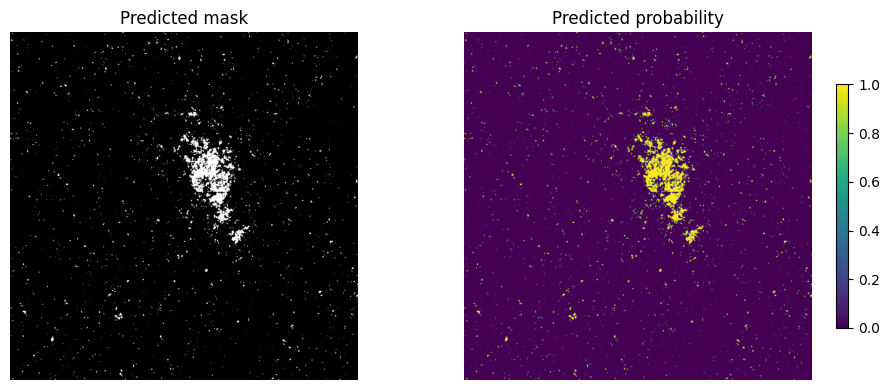

1


In [ ]:
# =============================
# 9) QUICK LOOK
# =============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Predicted mask")
plt.imshow(recon_mask, cmap='gray')
plt.axis('off')

if recon_prob is not None:
    plt.subplot(1,2,2)
    plt.title("Predicted probability")
    plt.imshow(recon_prob, vmin=0, vmax=1)
    plt.colorbar(shrink=0.7)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(np.max(np.max(recon_mask)))

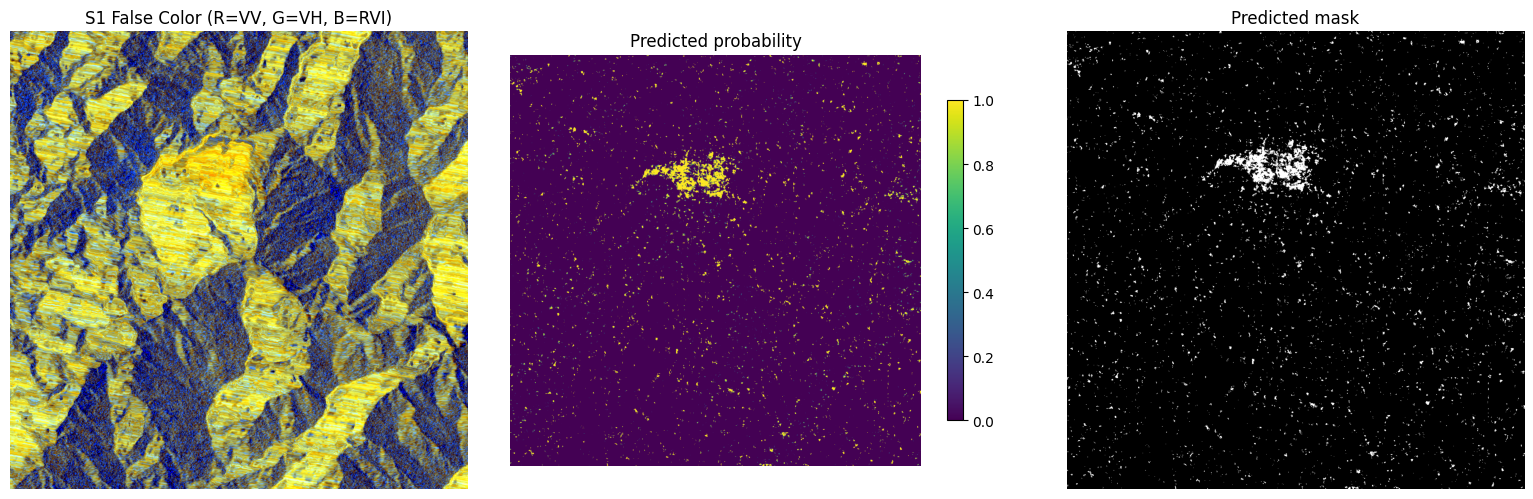

In [ ]:
# ======================================
# 9b) Show ORIGINAL Sentinel-1 composite
#      R = VV, G = VH, B = RVI (all normalized 0..1)
#      Uses the arr_scaled we built earlier from [VV, VH, RVI]
# ======================================
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Safety: make sure arr_scaled exists and has 3 bands [VV, VH, RVI]
assert 'arr_scaled' in globals() and arr_scaled.shape[-1] >= 3, \
    "arr_scaled with [VV, VH, RVI] not found. Make sure you ran the RVI-first-then-normalize step."

s1_rgb = np.dstack([
    arr_scaled[..., 0],   # VV → R
    arr_scaled[..., 1],   # VH → G
    arr_scaled[..., 2],   # RVI → B
]).astype(np.float32)
s1_rgb = np.clip(s1_rgb, 0, 1)

# Plot composite + predictions
cols = 3 if recon_prob is not None else 2
plt.figure(figsize=(16, 5))

plt.subplot(1, cols, 1)
plt.title("S1 False Color (R=VV, G=VH, B=RVI)")
plt.imshow(s1_rgb)
plt.axis('off')


if recon_prob is not None:
    plt.subplot(1, cols, 2)
    plt.title("Predicted probability")
    plt.imshow(recon_prob, vmin=0, vmax=1)
    plt.colorbar(shrink=0.7)
    plt.axis('off')

plt.subplot(1, cols, cols)
plt.title("Predicted mask")
plt.imshow(recon_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# --- RVI color map in subplot 1 ---
# If you followed the RVI-first-then-normalize step, RVI is arr_scaled[..., 2] in [0,1].
rvi_norm = arr_scaled[..., 2]

cols = 3 if recon_prob is not None else 2
fig, axes = plt.subplots(1, cols, figsize=(16, 5))

# Subplot 1: RVI (color)
im0 = axes[0].imshow(rvi_norm, cmap='turbo', vmin=0, vmax=1)
axes[0].set_title('RVI (scaled 0–1)')
axes[0].axis('off')
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02)
cbar0.set_label('RVI')

# Subplot 2 (optional): probability
if recon_prob is not None:
    im1 = axes[1].imshow(recon_prob, vmin=0, vmax=1)
    axes[1].set_title('Predicted probability')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02)

# Last subplot: mask
axes[-1].imshow(recon_mask, cmap='gray')
axes[-1].set_title('Predicted mask')
axes[-1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, pandas as pd
from scipy import ndimage as ndi
import rasterio
from rasterio.transform import xy

# binary mask: white=1, black=0
binary = (recon_mask > 0)

# 8-connected components
structure = np.ones((3,3), dtype=np.uint8)
labels, n = ndi.label(binary, structure=structure)

# per-component stats
areas_px = ndi.sum(binary, labels, index=np.arange(1, n+1))            # pixel count
slices   = ndi.find_objects(labels)                                     # bounding boxes
centers  = ndi.center_of_mass(binary, labels, index=np.arange(1, n+1))  # (row, col)

# pixel size from your earlier raster profile/transform
transform = profile["transform"]
resx = abs(transform.a)   # pixel width  (map units, e.g., meters)
resy = abs(transform.e)   # pixel height (map units, e.g., meters)

rows = []
for i, area in enumerate(areas_px, start=1):
    sl = slices[i-1]
    r0, r1 = sl[0].start, sl[0].stop
    c0, c1 = sl[1].start, sl[1].stop
    rr, cc = centers[i-1]                 # centroid in pixel coords (row, col)
    cx, cy = xy(transform, rr, cc)        # centroid in map coords (x, y)
    area_m2 = float(area) * resx * resy
    rows.append({
        "patch_id": i,
        "area_px": int(area),
        "area_m2": area_m2,
        "area_ha": area_m2 / 1e4,
        "centroid_row": rr, "centroid_col": cc,
        "centroid_x": cx, "centroid_y": cy,
        "bbox_min_row": r0, "bbox_min_col": c0,
        "bbox_max_row": r1, "bbox_max_col": c1
    })

df = pd.DataFrame(rows).sort_values("area_px", ascending=False).reset_index(drop=True)
print(df.head(10))          # top 10 largest patches
df.to_csv("patch_areas.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

# If you saved earlier: df = pd.read_csv("patch_areas.csv")
x = df["area_px"].astype(float)

# --- Linear scale (no extreme outliers) ---
plt.figure(figsize=(6,6))
plt.boxplot(x, vert=True, showfliers=False, whis=[5, 95])
plt.ylabel("Patch area (pixels)")
plt.title(f"White patch areas (N={len(x)})")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

# --- Log scale (helpful if distribution is skewed) ---
plt.figure(figsize=(6,6))
plt.boxplot(x, vert=True, showfliers=False, whis=[5, 95])
plt.yscale("log")
plt.ylabel("Patch area (pixels, log scale)")
plt.title(f"White patch areas (N={len(x)}) — log scale")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use patch areas (optionally drop tiny speckles)
x = df["area_px"].astype(float)
x = x[x > 0]              # keep positive areas
# x = x[x >= 50]          # <-- uncomment to ignore patches <50 px

# Freedman–Diaconis bin rule (robust bin count)
def fd_bins(data):
    if len(data) < 2:
        return 10
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    bw = 2 * iqr * (len(data) ** (-1/3))
    if bw <= 0:
        return 30
    return int(np.clip(np.ceil((data.max() - data.min()) / bw), 10, 200))

bins = fd_bins(x.values)

# --- Linear-scale histogram ---
plt.figure(figsize=(7,5))
plt.hist(x, bins=bins)
plt.xlabel("Patch area (pixels)")
plt.ylabel("Count")
plt.title(f"White patch areas (N={len(x)})")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Log-scale histogram with log-spaced bins ---
xpos = x[x > 0]
bins_log = np.logspace(np.log10(xpos.min()), np.log10(xpos.max()), 40)

plt.figure(figsize=(7,5))
plt.hist(xpos, bins=bins_log)
plt.xscale("log")
plt.xlabel("Patch area (pixels, log scale)")
plt.ylabel("Count")
plt.title(f"White patch areas (log bins, N={len(xpos)})")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
